# System State in the Temperature-Entropy Diagram
To always have a well-defined temperature for the system we need *diagonal* states throughout the evolution.
This is guarantee by the dynamical map if the system starts from a diagonal state.

The Otto cycle works like this:
- System starts in A at temperature $T_A$ and entropy $S_A$
    - **Isochore Stroke:** Going from A to B in stroke 1 the system absorbs heat from a *ground-coherent* phaseonium at tempreture $T_\eta$
- System is in B at temperature $T_B > T_A$ and entropy $S_B > S_A$, where $T_B \equiv T_\phi$ is dependent upon phaseonium coherences
    - **Adiabatic Stroke:** Going from B to C in stroke 2 the system do positive work on the environment
- System is in C at temperature $T_C < T_B$ with the same entropy as B, $S_C = S_B = S_h$
    - **Isochore Stroke:** Going from C to D in stroke 3 the system relase heat to a  *thermal* phaseonium at temperature $T_\eta$
- System is in D at temperature $T_D < T_C < T_A$ and entropy $S_D = S_A = S_l$, where $T_D = T_\eta$
    - **Adiabatic Stroke:** Going from D back to A in stroke 4 work is done on the system by *upper-coherent* phaseonium at temperature $T_\eta$ 

In [ ]:
import glob
from IPython.display import display, Image
import matplotlib.pyplot as plt
import numpy as np
import qutip as qt
from qutip.visualization import plot_fock_distribution, plot_wigner

import tqdm

import uuid
import json
import os

from thermophaseonium.utilities.make_gif import create_gif
from thermophaseonium.utilities.states import Cavity, Ancilla

SEED = 42
rng = np.random.default_rng(SEED)

OMEGA = 0.5  # Interaction strength
N = 200  # Maximum number of dimensions

INTERACTION_TIME = 0.02
T_MAX = 1000
TIMESTEPS = np.linspace(0, T_MAX, int(T_MAX / INTERACTION_TIME))
print(f"Total of {len(TIMESTEPS)} timesteps from 0 to {T_MAX} with dt = {INTERACTION_TIME}")

In [2]:
# This mapping is given by Wolfram Mathematica notebook 'thermal-ancillas-engine.nb'
# Going from A to B one uses ground-coherent phaseoniums
# Going from C to D one uses thermal phaseoniums
# Other strokes are done with other means
# Parameters are ( stable_temperature, alpha, phi )
PARAMETER_MAP = {
    'A': (1.5, 0.2, 2.56383),
    'B': (2, 0.2, 2.61119616),
    'C': (1, 0.2, 2.4551),
    'D': (0.5, 0.25175173948363, np.pi / 2),
}

In [3]:
def create_isobaric_ancilla(target_state = None):
    """
    This is an ancilla that only exchange heat with the system without doing work
    :return: 
    """
    alpha = PARAMETER_MAP[target_state][1] if target_state else 0.2
    heat_amplitude = (1 - alpha**2) / 2
    chi01_phase = np.pi * 0
    chi02_phase = np.pi * 1
    chi12_phase = PARAMETER_MAP[target_state][2] if target_state else np.pi * 4/5
    chi01 = np.cos(chi01_phase) + 1j * np.sin(chi01_phase)
    chi02 = np.cos(chi02_phase) + 1j * np.sin(chi02_phase)
    chi12 = heat_amplitude * (np.cos(chi12_phase) + 1j * np.sin(chi12_phase))
    
    ancilla = Ancilla([
        [alpha**2, chi01, chi02],
        [chi01.conjugate(), (1 - alpha**2)/2, chi12],
        [chi02.conjugate(), chi12.conjugate(), (1 - alpha**2)/2]
    ])
    return ancilla


def create_adiabatic_ancilla(work_sign='positive'):
    """
    This is an ancilla that do work on the system via the ground states - excited state coherences.
    Apparently, if the temperature of the respective thermal phaseonium is equal to that of the system, no heat is exchanged
    :return: 
    """
    alpha = 0.482386297
    work_amplitude = 1e-2
    chi01_phase = np.pi / 4 if work_sign == 'positive' else -np.pi / 6
    chi02_phase = np.pi / 4 if work_sign == 'positive' else -np.pi / 6
    # chi12_phase = np.pi * 0.5
    chi01 = work_amplitude * (np.cos(chi01_phase) + 1j * np.sin(chi01_phase))
    chi02 = work_amplitude * (np.cos(chi02_phase) + 1j * np.sin(chi02_phase))
    # chi12 = ( np.cos(chi12_phase) + 1j * np.sin(chi12_phase) )
    # chi12 = 0 + 1j
    chi12 = 0
    ancilla = Ancilla([
        [alpha**2, chi01, chi02],
        [chi01.conjugate(), (1 - alpha**2)/2, chi12],
        [chi02.conjugate(), chi12.conjugate(), (1 - alpha**2)/2]
    ])
    
    return ancilla


def create_thermal_ancilla(target_state):
    """This is an ancilla with the same 'temperature' as the others, in a Gibbs state"""
    alpha = PARAMETER_MAP[target_state][1] if target_state else 0.2
    beta = np.sqrt(1 - alpha**2)
    ancilla = Ancilla([
        [alpha**2, 0, 0],
        [0, beta**2/2, 0],
        [0, 0, beta**2/2]
    ])
    return ancilla


ancilla_coherent = create_isobaric_ancilla(target_state='B')
ancilla_thermal = create_thermal_ancilla(target_state='D')
ancilla_adiabatic = create_adiabatic_ancilla()
print(f"Target temperature for B: {ancilla_coherent.stable_temperature}")
print(f"Target temperature for D: {ancilla_thermal.stable_temperature}")
print(f"Target temperature for C: {ancilla_adiabatic.stable_temperature}")
ancilla_adiabatic

Target temperature for B: 2.00000003482211
Target temperature for D: 0.4999999999999827
Target temperature for C: 2.00000004288963


Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.23269654+0.j         0.00707107+0.00707107j 0.00707107+0.00707107j]
 [0.00707107-0.00707107j 0.38365173+0.j         0.        +0.j        ]
 [0.00707107-0.00707107j 0.        +0.j         0.38365173+0.j        ]]

In [4]:
TEMPERATURE_TO_PHOTON_MAP = {
    0.5: 0.156518,
    1.0: 0.5819767068693264,
    1.5: 1.0551483399,
    2.0: 1.541494082537,
}
system_temperature = 2.0
n_photons = TEMPERATURE_TO_PHOTON_MAP[system_temperature]
system = Cavity(qt.thermal_dm(N, n_photons), omega=1)

system.temperature

2.000000000000206

## Evolution

In [5]:
def H_work(ancilla, a, omega=OMEGA):
    chi01 = ancilla.chi01
    chi02 = ancilla.chi02
    upshift = (chi01 + chi02) * a.dag()
    return omega * (upshift + upshift.dag())

In [6]:
def D(op1, rho, op2=None):
    if op2 is None:
        op2 = op1
    return op1 * rho * op2.dag() - qt.commutator(op2.dag() * op1, rho, kind='anti') / 2

In [7]:
def onestep_evolution(rho, eta, a, dt=INTERACTION_TIME, o=OMEGA):
    work = 1j * o * dt * qt.commutator(H_work(eta, a), rho)
    heat1 = eta.ga * ( o * dt ) ** 2 * D(qt.create(N), rho)
    heat2 = eta.gb * ( o * dt ) ** 2 * D(qt.destroy(N), rho)
    # rho_new = rho + work + heat1 + heat2
    rho_new = rho + work
    return rho_new

In [8]:
def hilbert_is_good(rho, threshold=1e-6):
    """
    Check if the last element of the density matrix is almost null
    """
    return 0 <= abs(rho[-1, -1]) < threshold

In [9]:
def new_ancilla(ancilla, method='static', **kwargs):
    if method == 'static':
        return ancilla
    elif method == 'rotating':
        phis = np.linspace(0, 2 * np.pi, kwargs.get('timesteps', 10))
        ancilla.chi01 = phis[kwargs.get('step', -1)]
        ancilla.chi02 = phis[kwargs.get('step', -1)]
        return ancilla
    else:
        raise ValueError(f"Method {method} not recognized")


In [23]:
def stroke(system, ancilla, timesteps, start=None, end=None, n=None, t_stop=None):
    
    temperature_evolution = np.zeros(len(timesteps))
    entropy_evolution = np.zeros(len(timesteps))
    time_evolution = np.zeros(len(timesteps))
    
    a = qt.destroy(N)
    
    if start and end:
        print(f"Starting stroke {n} from {start} to {end}")
    print(f"Starting system temperature: {system.temperature}")
    for k, t in enumerate(tqdm.tqdm(timesteps, desc=f"Stroke")):
        temperature_evolution[k] = system.temperature
        entropy_evolution[k] = system.entropy
        
        time_evolution[k] = t
        try:
            rho_new =  Cavity(onestep_evolution(system, ancilla, a))
        except ValueError as e:
            print(f"Error in computing the evolution at step {k} with t = {t}: {e}")
            # Return the last good state and the evolution up to this point
            return Cavity(system), temperature_evolution[:k], entropy_evolution[:k], time_evolution[:k]

        if not hilbert_is_good(system):
            print(f"Approximation no more valid at step {k} with t = {t}")
            return Cavity(system), temperature_evolution[:k], entropy_evolution[:k], time_evolution[:k]
        
        if t_stop is not None and rho_new.temperature - t_stop < 1e-4:
            print(f"Reached the temperature {rho_new.temperature}")
            return Cavity(system), temperature_evolution[:k], entropy_evolution[:k], time_evolution[:k]
        
        # Update the state
        system = Cavity(rho_new)
    
    return system, temperature_evolution, entropy_evolution, time_evolution

## Adiabatic Stroke
Can we *lower* the temperature of a system?

In [24]:
ancilla_adiabatic = create_adiabatic_ancilla('positive')
rho = system
rho, temperature_evolution, entropy_evolution, time_evolution = stroke(rho, ancilla_adiabatic, TIMESTEPS[:])

Starting system temperature: 2.000000000000206


Stroke: 100%|██████████| 250000/250000 [59:42<00:00, 69.79it/s]


In [25]:
temperature_evolution[0:10]
print(entropy_evolution[0:2])
print(entropy_evolution[-2:])

[1.70349917 1.70349917]
[1.70349803 1.70349803]


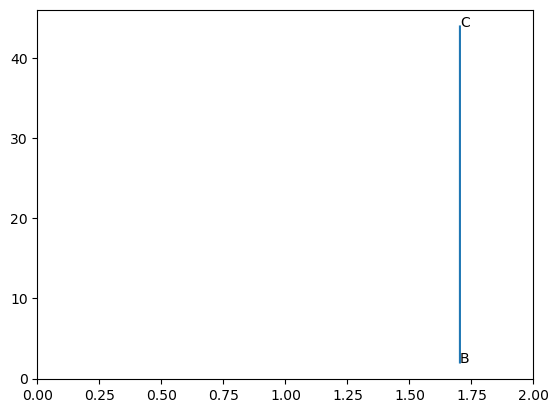

In [26]:
plt.plot(entropy_evolution, temperature_evolution)
plt.text(entropy_evolution[0], temperature_evolution[0], 'B')
plt.text(entropy_evolution[-1], temperature_evolution[-1], 'C')
plt.xlim((0, 2))
plt.show()

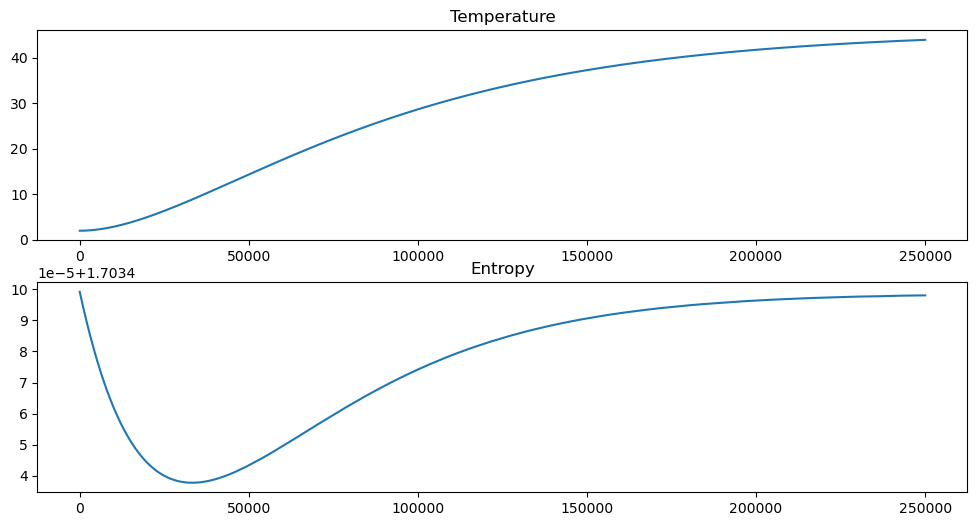

In [31]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))
ax1.plot(temperature_evolution)
ax1.set_title('Temperature')
ax2.plot(entropy_evolution)
ax2.set_title('Entropy')
plt.show()

Stroke: 100%|██████████| 2000/2000 [00:11<00:00, 176.90it/s]


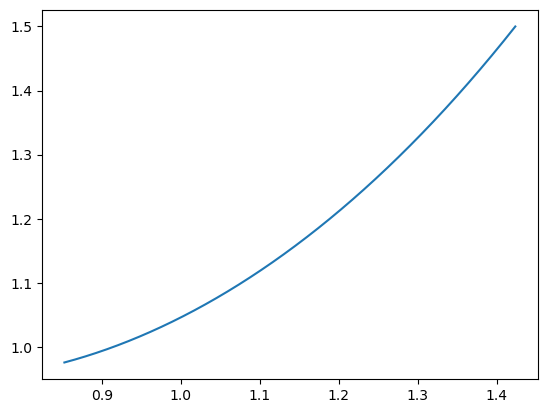

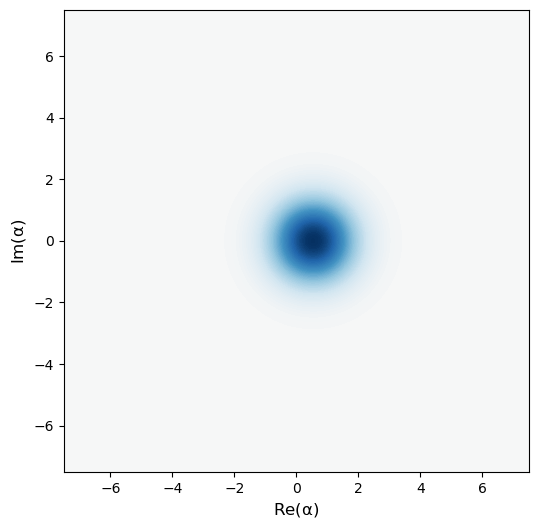

(<Figure size 600x600 with 1 Axes>,
 <Axes: xlabel='$\\rm{Re}(\\alpha)$', ylabel='$\\rm{Im}(\\alpha)$'>)

In [148]:
ancilla_adiabatic = create_adiabatic_ancilla('negative')
rho = system
rho, temperature_evolution, entropy_evolution, time_evolution = stroke(rho, ancilla_adiabatic, TIMESTEPS[:2000])
plt.plot(entropy_evolution, temperature_evolution)
plt.show()
rho.plot_wigner()

# Otto Cycle

In [122]:
rho = system

temperatures = []
entropies = []
times = []

## Stroke 2
In this **adiabatic stroke** the system do positive work to the environment without heat exchange. This stroke is "syntethic" and it is not simulated; it depends on the real implementation of the Quantum Engine.
We go from B with $T_B,\, S_B$ to C with $T_C < T_B$ and $S_C = S_B \equiv S_h$

In [125]:
#We start with the last temperature and entropy of stroke 1
T_B = temperatures[0][-1]
S_h = entropies[0][-1]
# While entropy remains constant, temperature goest from T_B to T_C
T_C = PARAMETER_MAP['C'][0]

temperatures.append([T_B, T_C])
entropies.append([S_h, S_h])

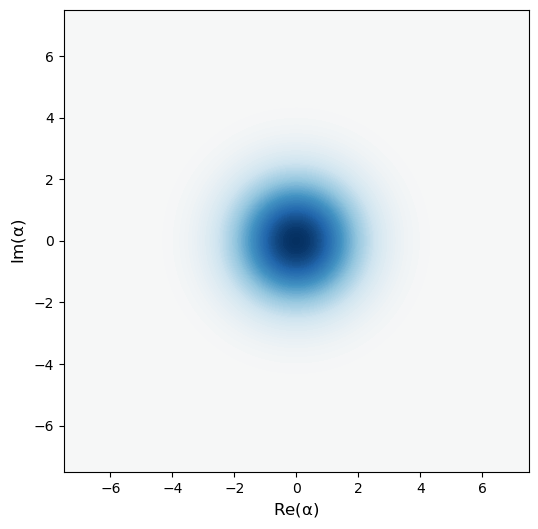

(<Figure size 600x600 with 1 Axes>,
 <Axes: xlabel='$\\rm{Re}(\\alpha)$', ylabel='$\\rm{Im}(\\alpha)$'>)

In [127]:
rho.plot_wigner()

## Stroke 3
In this **isobaric stroke** the system is coupled to thermal phaseoniums and cools down without doing work.
We go from C with $T_C,\, S_h$ to D with $T_C > T_D \equiv T_\eta$ and $S_h > S_D \equiv S_l$

In [17]:
# Isobaric stroke
ancilla_thermal = create_thermal_ancilla('D')
rho, temperature_evolution, entropy_evolution, time_evolution = stroke(rho, ancilla_thermal, TIMESTEPS, start='C', end='D', n='3')
temperatures.append(temperature_evolution)
entropies.append(entropy_evolution)
times.append(time_evolution)

Starting stroke 3 from C to D


Stroke:  16%|█▌        | 15575/100000 [01:19<07:12, 195.20it/s]

Error in computing the evolution at step 15575 with t = 778.7577875778758: Input is not a valid density matrix


## Stroke 4
In this **adiabatic stroke** work is done on the system by upper-coherent phaseoniums. No heat is exchanged. When the temperature of the systems comes back to that of A, the evolution stops
We go from B with $T_B,\, S_B$ to C with $T_C < T_B$ and $S_C = S_B \equiv S_h$

In [18]:
# Adiabatic stroke
ancilla_adiabatic = create_adiabatic_ancilla(work_sign='positive')
rho, temperature_evolution, entropy_evolution, time_evolution = stroke(rho, ancilla_adiabatic, TIMESTEPS, start='C', end='D', n='3', t_stop=1.5)
temperatures.append(temperature_evolution)
entropies.append(entropy_evolution)
times.append(time_evolution)

Starting stroke 3 from C to D


Stroke:   0%|          | 62/100000 [00:00<12:19, 135.08it/s]

Error in computing the evolution at step 62 with t = 3.100031000310003: Input is not a valid density matrix


## Stroke 1
In this **isobaric stroke** the system is coupled to ground-coherent phaseoniums and it is allowed to thermalize while its Hamiltonian is held constant.
We go from A with $T_A,\, S_A$ to B with $T_A < T_B \equiv T_\phi$ and $S_A < S_B$

In [123]:
# Isobaric stroke
ancilla_isobaric = create_isobaric_ancilla('B')
rho, temperature_evolution, entropy_evolution, time_evolution = stroke(rho, ancilla_isobaric, TIMESTEPS, start='A', end='B', n='1')
temperatures.append(temperature_evolution)
entropies.append(entropy_evolution)
times.append(time_evolution)

print(f"System reached the temperature {rho.temperature}")

Starting stroke 1 from A to B


Stroke: 100%|██████████| 100000/100000 [09:23<00:00, 177.33it/s]

System reached the temperature 1.9806719051556032


## Plot the Cycle